In [2]:
import itertools
import numpy as np
import pandas as pd
import ds_charts as ds
from datetime import datetime
import matplotlib.pyplot as plt
from seaborn import distplot,heatmap
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

In [3]:
#Definição variáveis iniciais
#register_matplotlib_converters()

#read_file = pd.read_excel ("XAI - Limpo.xlsx")
#read_file.to_csv ("XAI - Limpo.csv", index = None,header=True)

file = "./Csvs/XAI - Limpo.csv"
tc = "surgycal margin" 
data = pd.read_csv(file,index_col=tc,na_values='')
df = pd.DataFrame(data)
data.shape
data.dtypes

Age.at.MRI                                     float64
Prostate.volume                                  int64
PSA.value.at.MRI                               float64
Index.lesion.PIRADS.V2                           int64
Index.lesion.size                                int64
Capsular.contact.lenght_TLC                      int64
Smooth.capsular.bulging                          int64
Capsular.disruption                              int64
Unsharp.margin                                   int64
Irregular.contour                                int64
Black.estrition.periprostatic.fat                int64
Retoprostatic.angle.obliteration                 int64
Measurable.ECE                                   int64
ECE.in.prostatectomy.specimen_gold.standard      int64
Gleason.score                                    int64
regra                                            int64
dtype: object

{'binary': ['Smooth.capsular.bulging', 'Capsular.disruption', 'Unsharp.margin', 'Irregular.contour', 'Black.estrition.periprostatic.fat', 'Retoprostatic.angle.obliteration', 'Measurable.ECE', 'ECE.in.prostatectomy.specimen_gold.standard', 'Gleason.score', 'regra'], 'numeric': ['Age.at.MRI', 'Prostate.volume', 'PSA.value.at.MRI', 'Index.lesion.size', 'Capsular.contact.lenght_TLC'], 'date': [], 'symbolic': ['Index.lesion.PIRADS.V2']}


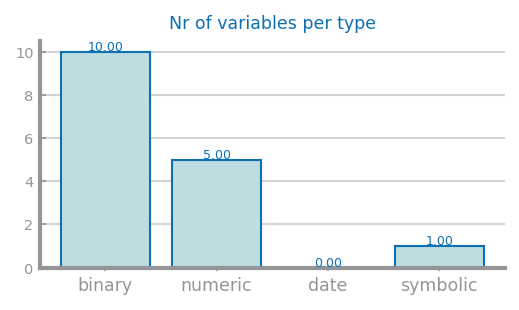

In [4]:
#Cálculo das variáveis
variable_types = ds.get_variable_types(data)
print(variable_types)
counts = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])
plt.figure(figsize=(4,2))
ds.bar_chart(list(counts.keys()), list(counts.values()), title='Nr of variables per type')
#plt.savefig('Images/variable_types.png')
plt.show()

#Tipos das variáveis
binary_vars = variable_types['binary']
numeric_vars = variable_types['numeric']
symbolic_vars = variable_types['symbolic']

In [ ]:
#Cálculo dos missing values
mv = {}
for var in data:
    nr = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr
plt.figure()
ds.bar_chart(list(mv.keys()), list(mv.values()), title='Nr of missing values per variable',xlabel='variables', ylabel='nr missing values', rotation=True)
#plt.savefig('images/mv.png')
plt.show()

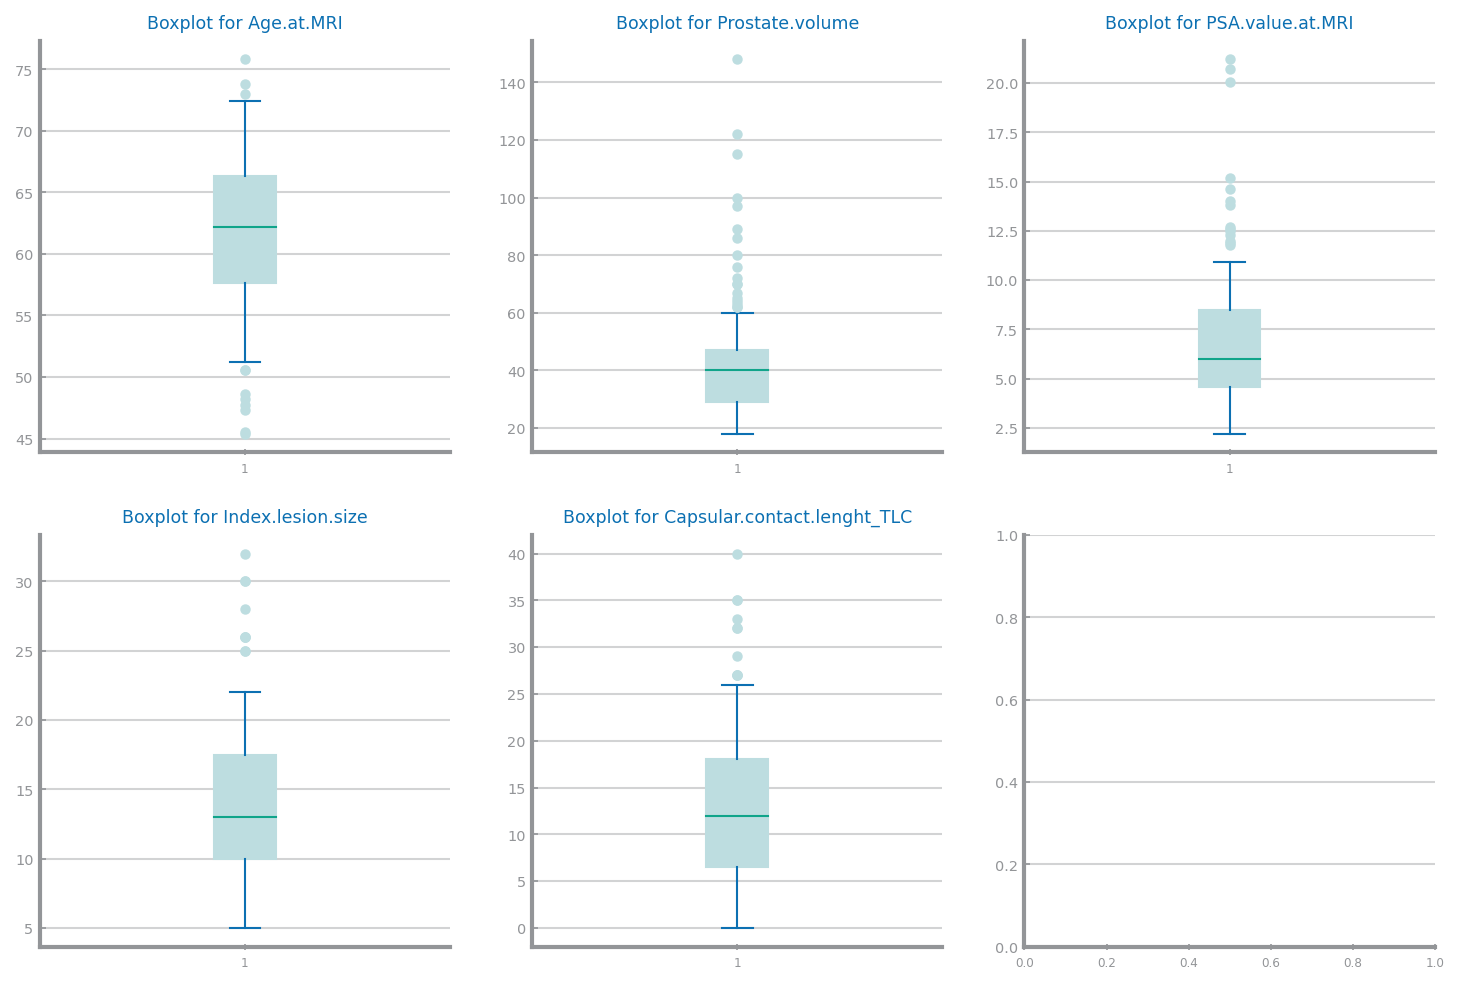

In [7]:
#Boxplot das variáveis numéricas
rows, cols = ds.choose_grid(len(numeric_vars))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT), squeeze=False)
i, j = 0, 0
for n in range(len(numeric_vars)):
    axs[i, j].set_title('Boxplot for %s'%numeric_vars[n])
    axs[i, j].boxplot(data[numeric_vars[n]].dropna().values)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
#plt.savefig('images/single_boxplots.png')
plt.show()

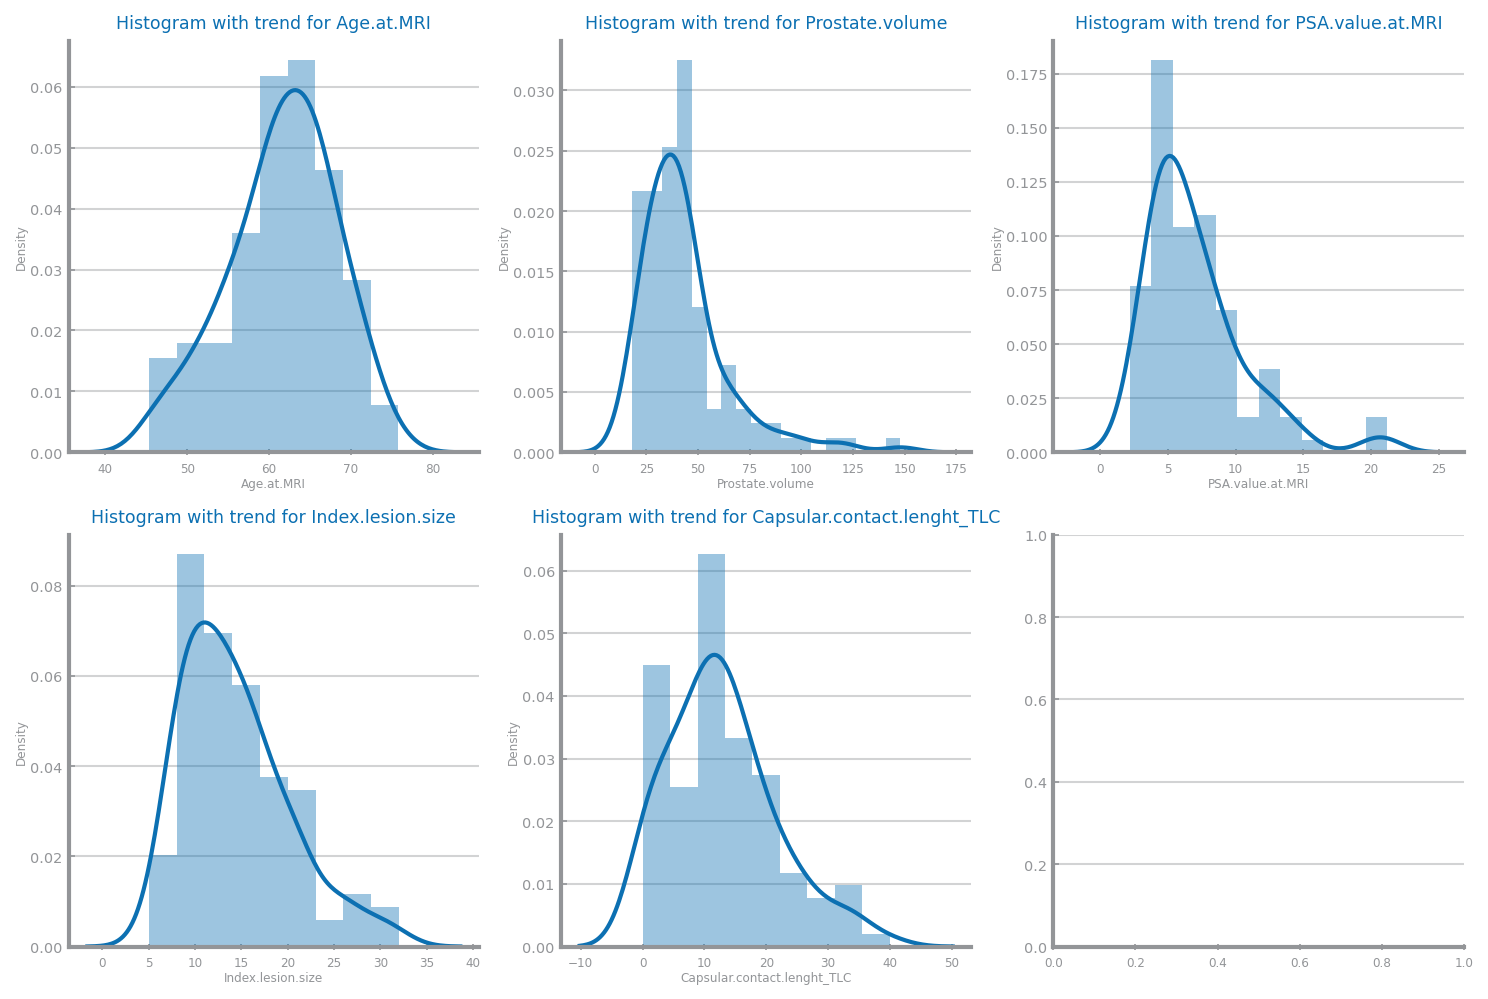

In [8]:
#Histogramas das variáveis numéricas com trendlines
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT), squeeze=False)
i, j = 0, 0
for n in range(len(numeric_vars)):
    axs[i, j].set_title('Histogram with trend for %s'%numeric_vars[n])
    distplot(data[numeric_vars[n]].dropna().values, norm_hist=True, ax=axs[i, j], axlabel=numeric_vars[n])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
#plt.savefig('images/histograms_trend_numeric.png')
plt.show()

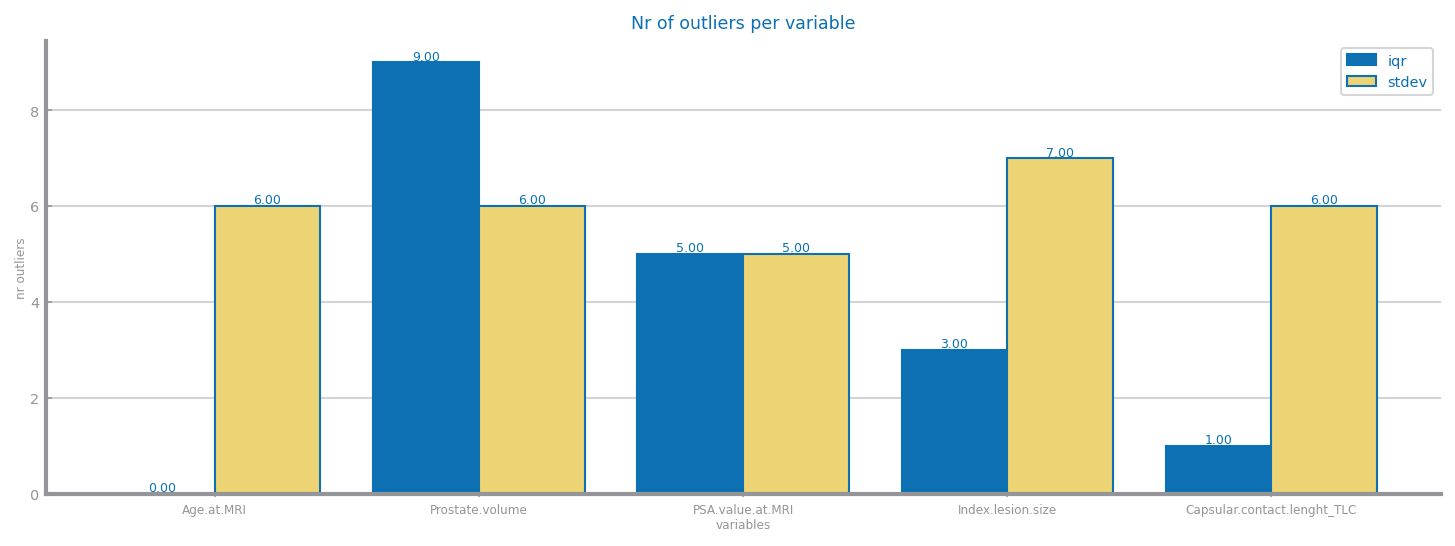

In [9]:
#Verificação dos outliers usandos os critérios de IQR e stdev
NR_STDEV: int = 2
outliers_iqr = []
outliers_stdev = []
summary5 = data.describe(include='number')
for var in numeric_vars:
    iqr = 1.5 * (summary5[var]['75%'] - summary5[var]['25%'])
    outliers_iqr += [
        data[data[var] > summary5[var]['75%']  + iqr].count()[var] +
        data[data[var] < summary5[var]['25%']  - iqr].count()[var]]
    std = NR_STDEV * summary5[var]['std']
    outliers_stdev += [
        data[data[var] > summary5[var]['mean'] + std].count()[var] +
        data[data[var] < summary5[var]['mean'] - std].count()[var]]
outliers = {'iqr': outliers_iqr, 'stdev': outliers_stdev}
plt.figure(figsize=(12, ds.HEIGHT))
ds.multiple_bar_chart(numeric_vars, outliers, title='Nr of outliers per variable', xlabel='variables', ylabel='nr outliers', percentage=False)
#plt.savefig('images/outliers.png')
plt.show()

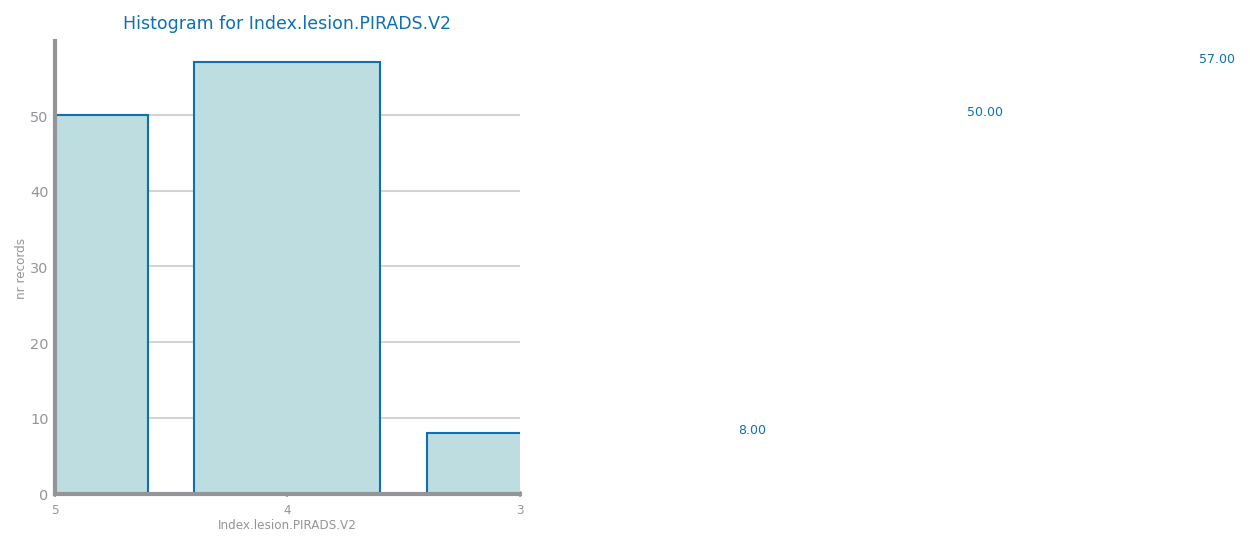

In [10]:
#Variáveis Simbólicas
rows, cols = ds.choose_grid(len(symbolic_vars))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT), squeeze=False)
i, j = 0, 0
for n in range(len(symbolic_vars)):
    counts = data[symbolic_vars[n]].value_counts()
    ds.bar_chart(counts.index.to_list(), counts.values, ax=axs[i, j], title='Histogram for %s'%symbolic_vars[n], xlabel=symbolic_vars[n], ylabel='nr records', percentage=False)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
#plt.savefig('images/histograms_symbolic.png')
plt.show()

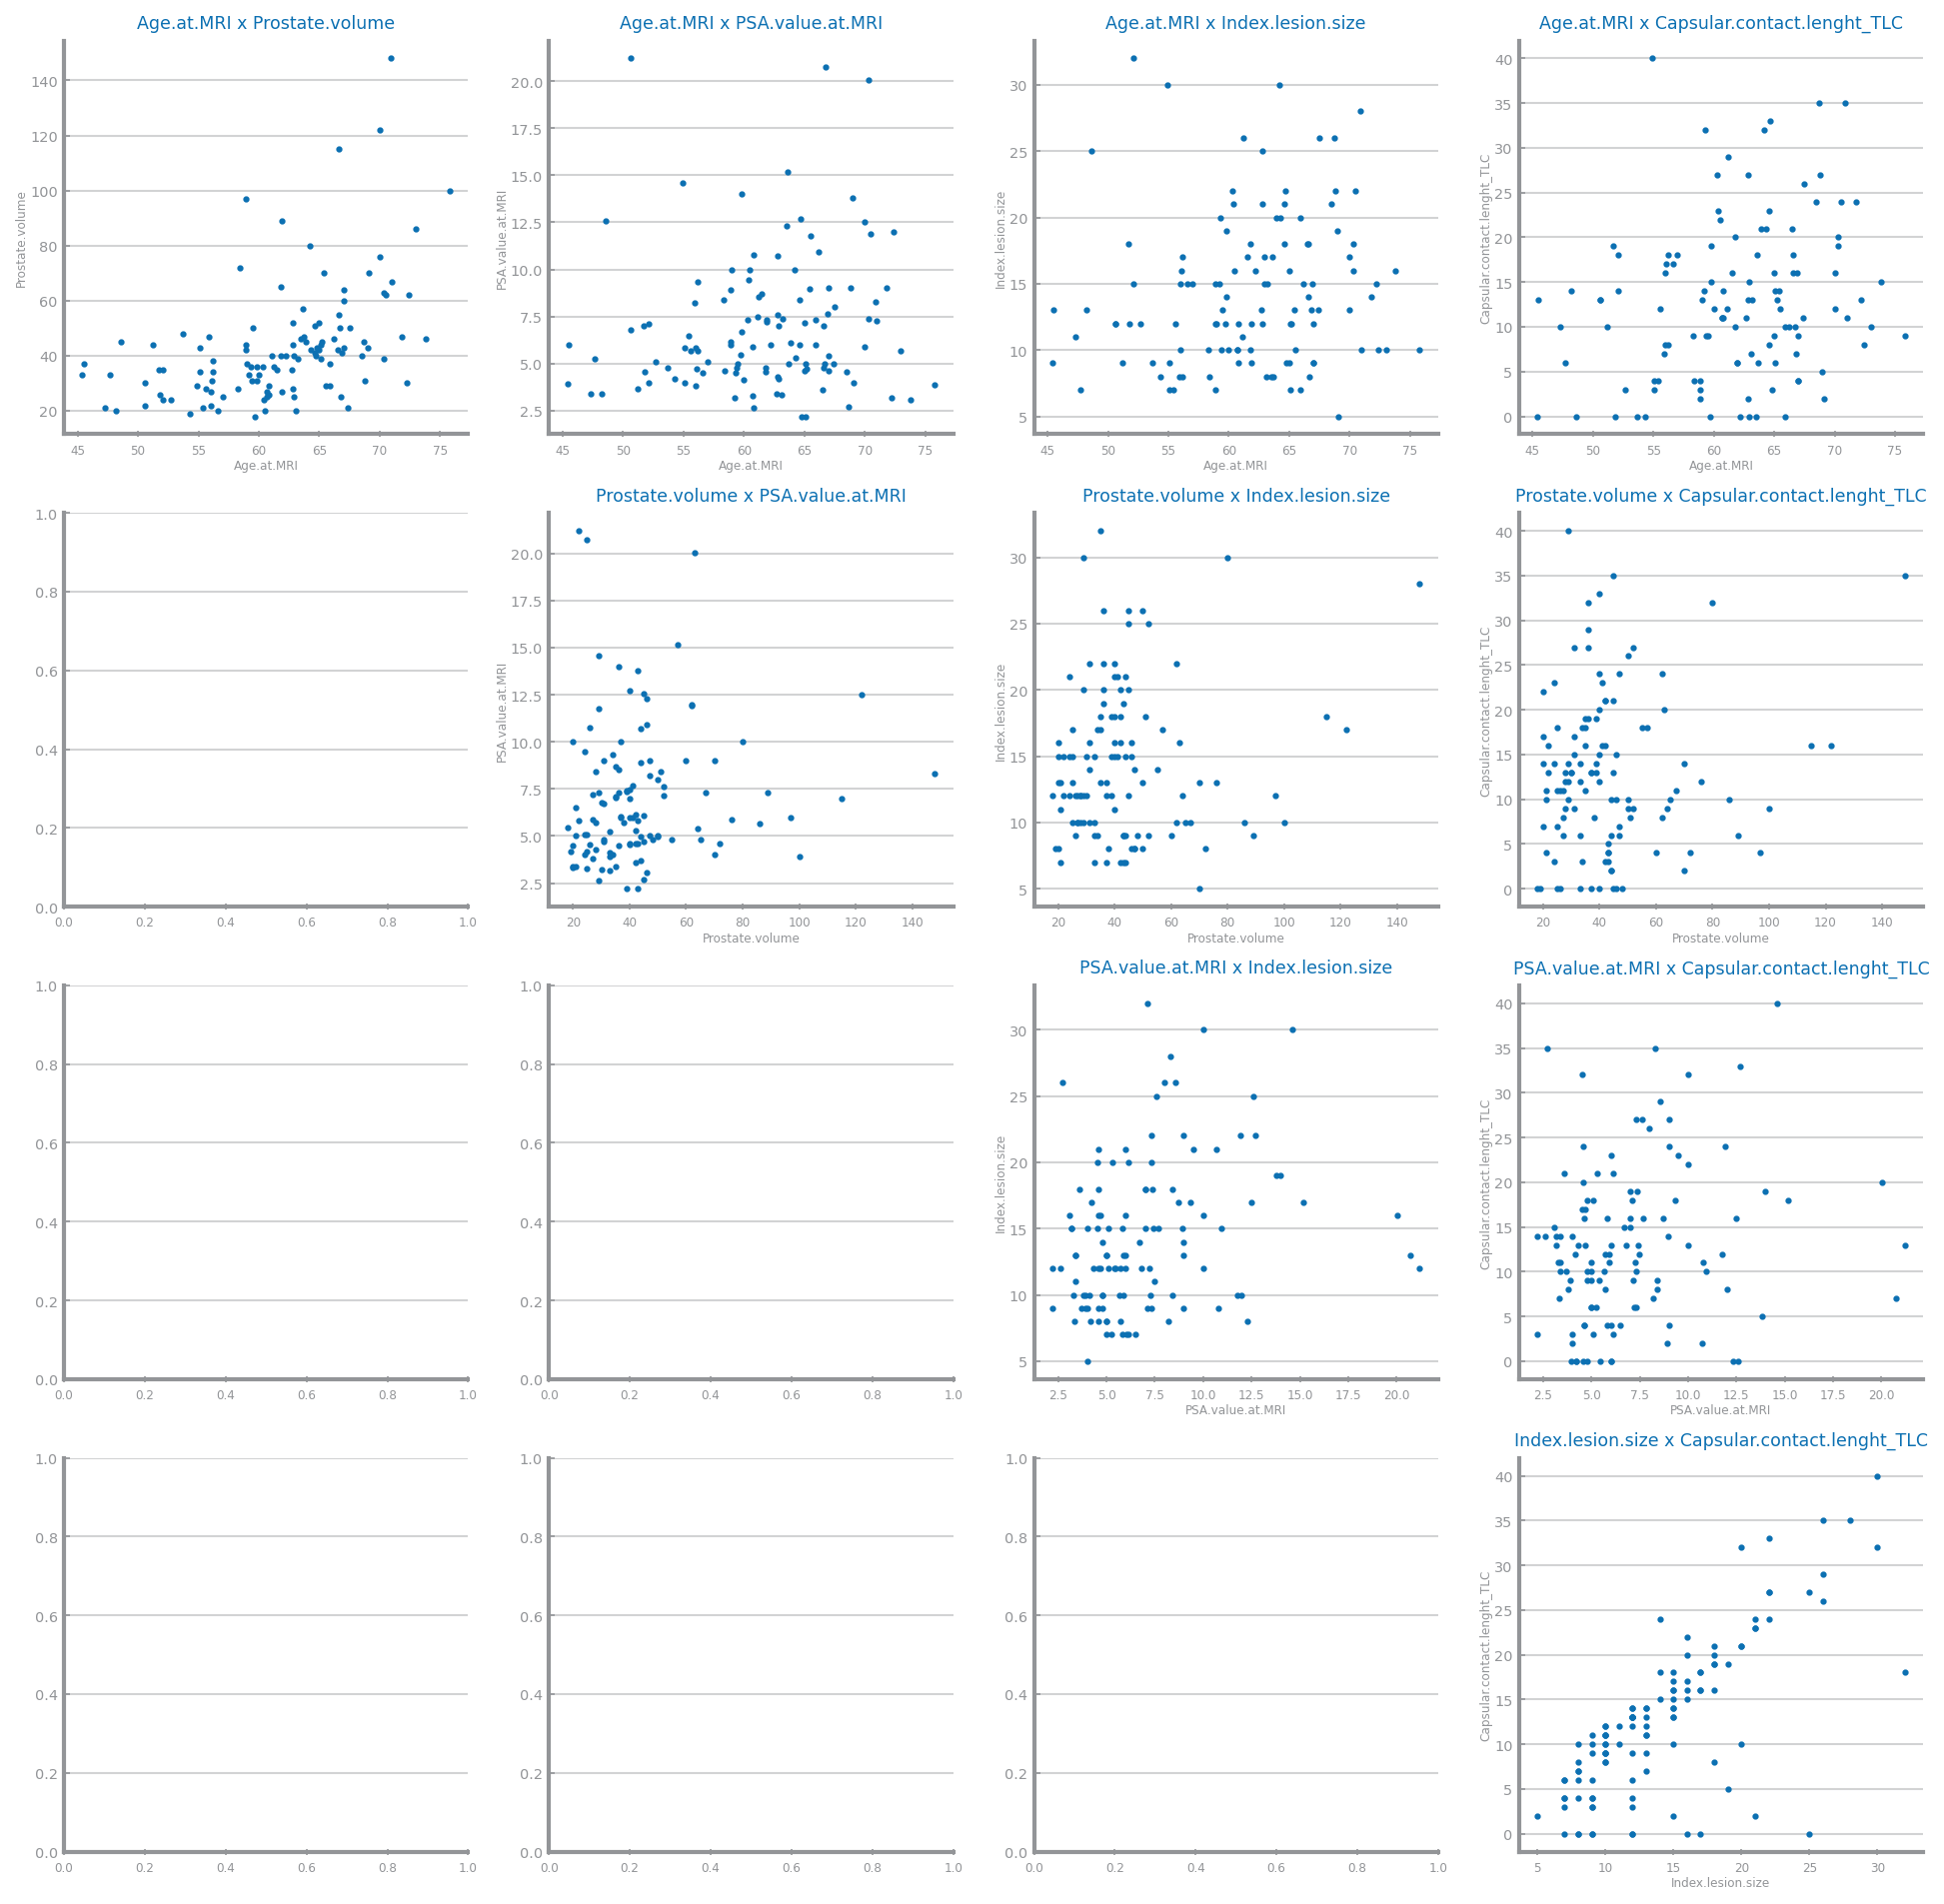

In [11]:
#Análise da sparsity - variáveis numéricas
rows, cols = len(numeric_vars)-1, len(numeric_vars)-1
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT), squeeze=False)
for i in range(len(numeric_vars)):
    var1 = numeric_vars[i]
    for j in range(i+1, len(numeric_vars)):
        var2 = numeric_vars[j]
        axs[i, j-1].set_title("%s x %s"%(var1,var2))
        axs[i, j-1].set_xlabel(var1)
        axs[i, j-1].set_ylabel(var2)
        axs[i, j-1].scatter(data[var1], data[var2])
#plt.savefig(f'images/sparsity_study_numeric.png')
plt.show()

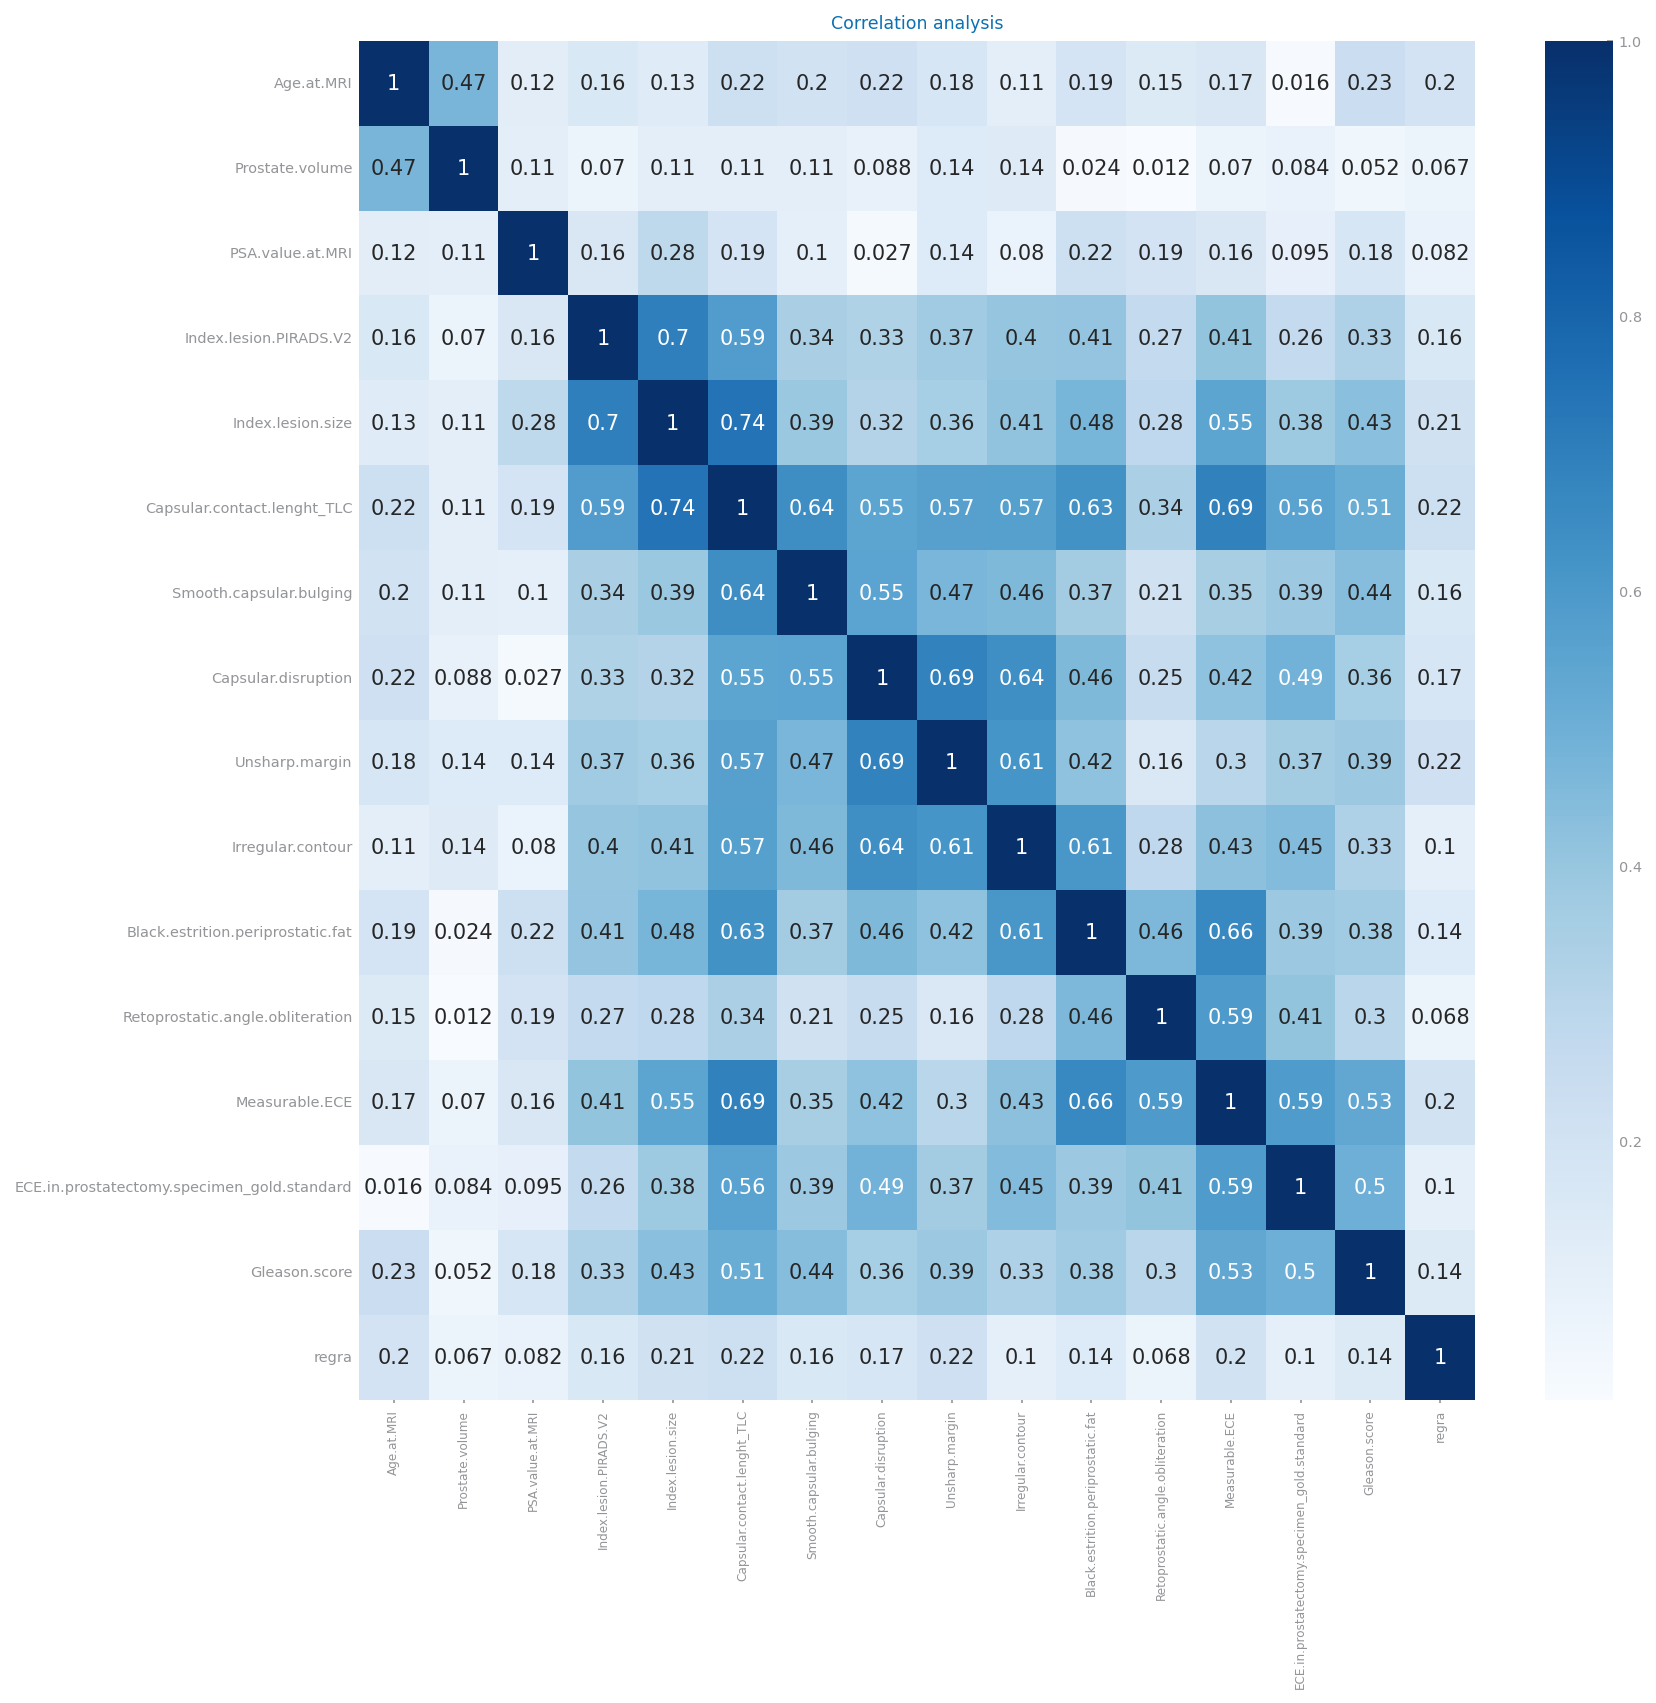

In [12]:
#Análise correlacional - heatmap
corr_mtx = abs(data.corr())
#print(corr_mtx)

fig = plt.figure(figsize=[12, 12])
heatmap(abs(corr_mtx), xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
#plt.savefig(f'images/correlation_analysis.png')
plt.show()